In [1]:
import os
import yaml
import torch
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from PIL import Image
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Train

In [2]:

# 1. Setup Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print("Device:", DEVICE)

Device: cuda


In [3]:
# 2. Load Config & CSV Splits
ROOT = Path.cwd().parent
CONFIG_PATH = ROOT / "config" / "data_config.yaml"
SPLIT_PATH = ROOT / "data_splits"

with open(CONFIG_PATH) as f:
    config = yaml.safe_load(f)

IMG_SIZE = config["IMG_SIZE"]
BATCH_SIZE = config["BATCH_SIZE"]
CLASSES = config["CLASSES"]
NUM_CLASSES = config["NUM_CLASSES"]
MEAN = config["NORMALIZE_MEAN"]
STD = config["NORMALIZE_STD"]

train_df = pd.read_csv(SPLIT_PATH / "train_split.csv")
val_df = pd.read_csv(SPLIT_PATH / "val_split.csv")
test_df = pd.read_csv(SPLIT_PATH / "test_split.csv")

In [4]:

# 3. Define Transforms
class RGBA2RGB:
    def __call__(self, img):
        if img.mode == "RGBA":
            img = img.convert("RGB")
        elif img.mode == "L":
            img = img.convert("RGB")
        return img

train_transform = transforms.Compose([
    RGBA2RGB(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(
        brightness=0.2, contrast=0.2, saturation=0.2
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD),
])

val_test_transform = transforms.Compose([
    RGBA2RGB(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD),
])

In [5]:
# 4. Dataset
class CropDataset(Dataset):
    def __init__(self, df, transforms=None):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.transforms = transforms
        self.labels = sorted(df.labels.unique())
        self.cls_2_idx = {}
        self.idx_2_cls = {}
        for i, crp in enumerate(self.labels):
            self.cls_2_idx[crp] = i
            self.idx_2_cls[i] = crp
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        image_path = self.df.iloc[index]['image_paths']
        label = self.df.iloc[index]['labels']
        image = Image.open(image_path).convert("RGB")
        if self.transforms:
            image = self.transforms(image)
        label_idx = self.cls_2_idx[label]
        return image, label_idx        

In [6]:
# 5. Dataset and Dataloaders
train_dataset = CropDataset(train_df, train_transform)
val_dataset = CropDataset(val_df, val_test_transform)
test_dataset = CropDataset(test_df, val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                        shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                        shuffle=False)

In [7]:
# 6. Create model
model = models.resnet18(weights='DEFAULT') 
model.fc = nn.Linear(in_features=512, out_features=NUM_CLASSES)
model = model.to(DEVICE)

In [8]:
# 7. Loss, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2
)

In [9]:
# 8. Train loop
EPOCHS = 50
best_val_loss = float("inf")

for epoch in range(EPOCHS):
    #  TRAIN 
    model.train()
    total_loss = 0
    correct = 0

    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

    train_loss = total_loss / len(train_loader)
    train_acc = correct / len(train_dataset)

    #  VALIDATE 
    model.eval()
    val_loss_total = 0
    val_correct = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            val_loss_total += loss.item()
            val_correct += (outputs.argmax(1) == labels).sum().item()

    val_loss = val_loss_total / len(val_loader)
    val_acc = val_correct / len(val_dataset)

    scheduler.step(val_loss)
    if (epoch + 1) % 10 == 0:
        print(f"""
        Epoch [{epoch+1}/{EPOCHS}]
        Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}
        Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}
        """)

    # save best
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        model_path = ROOT / "checkpoints" / "best_model.pt"
        model_path.parent.mkdir(exist_ok=True)
        torch.save(model.state_dict(), model_path)
        print(f"Saved best model at: {model_path}")


print("Training complete!")

Epoch 1/50: 100%|██████████| 17/17 [00:04<00:00,  3.59it/s]


Saved best model at: /home/hongquan/Documents/GitHub/agri-crop-classification/checkpoints/best_model.pt


Epoch 3/50: 100%|██████████| 17/17 [00:04<00:00,  4.05it/s]


Saved best model at: /home/hongquan/Documents/GitHub/agri-crop-classification/checkpoints/best_model.pt


Epoch 4/50: 100%|██████████| 17/17 [00:04<00:00,  4.04it/s]


Saved best model at: /home/hongquan/Documents/GitHub/agri-crop-classification/checkpoints/best_model.pt


Epoch 5/50: 100%|██████████| 17/17 [00:04<00:00,  3.98it/s]


Saved best model at: /home/hongquan/Documents/GitHub/agri-crop-classification/checkpoints/best_model.pt


Epoch 10/50: 100%|██████████| 17/17 [00:04<00:00,  3.97it/s]



        Epoch [10/50]
        Train Loss: 0.1518 | Train Acc: 0.9732
        Val Loss:   5.3080 | Val Acc:   0.2241
        
Saved best model at: /home/hongquan/Documents/GitHub/agri-crop-classification/checkpoints/best_model.pt


Epoch 20/50: 100%|██████████| 17/17 [00:04<00:00,  3.96it/s]



        Epoch [20/50]
        Train Loss: 0.0217 | Train Acc: 0.9981
        Val Loss:   6.6143 | Val Acc:   0.2414
        


Epoch 30/50: 100%|██████████| 17/17 [00:04<00:00,  3.92it/s]



        Epoch [30/50]
        Train Loss: 0.0144 | Train Acc: 1.0000
        Val Loss:   6.6091 | Val Acc:   0.2414
        


Epoch 40/50: 100%|██████████| 17/17 [00:04<00:00,  4.02it/s]



        Epoch [40/50]
        Train Loss: 0.0425 | Train Acc: 0.9962
        Val Loss:   6.6112 | Val Acc:   0.2414
        


Epoch 50/50: 100%|██████████| 17/17 [00:04<00:00,  3.98it/s]



        Epoch [50/50]
        Train Loss: 0.0190 | Train Acc: 0.9981
        Val Loss:   6.6668 | Val Acc:   0.2414
        
Training complete!


## Evaluate 

In [10]:
idx_2_cls = train_dataset.idx_2_cls

all_preds = []
all_labels = []

# Disable grad
with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Evaluating"):
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 1. Accuracy
correct = sum(p == t for p, t in zip(all_preds, all_labels))
acc = correct / len(all_labels)

print(f"\nTest Accuracy: {acc * 100:.2f}%\n")

Evaluating: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Test Accuracy: 75.10%



Classification Report:
                     precision    recall  f1-score   support

             Cherry       0.69      0.90      0.78        10
       Coffee-plant       0.62      0.56      0.59         9
           Cucumber       0.80      0.89      0.84         9
   Fox_nut(Makhana)       0.71      0.71      0.71         7
              Lemon       1.00      0.75      0.86         8
         Olive-tree       0.45      0.56      0.50         9
Pearl_millet(bajra)       0.71      0.83      0.77        12
      Tobacco-plant       0.67      0.40      0.50        10
             almond       0.67      0.33      0.44         6
             banana       0.64      0.78      0.70         9
           cardamom       0.60      0.43      0.50         7
             chilli       0.71      0.71      0.71         7
              clove       0.78      0.78      0.78         9
            coconut       1.00      1.00      1.00         7
             cotton       0.90      0.90      0.90        10


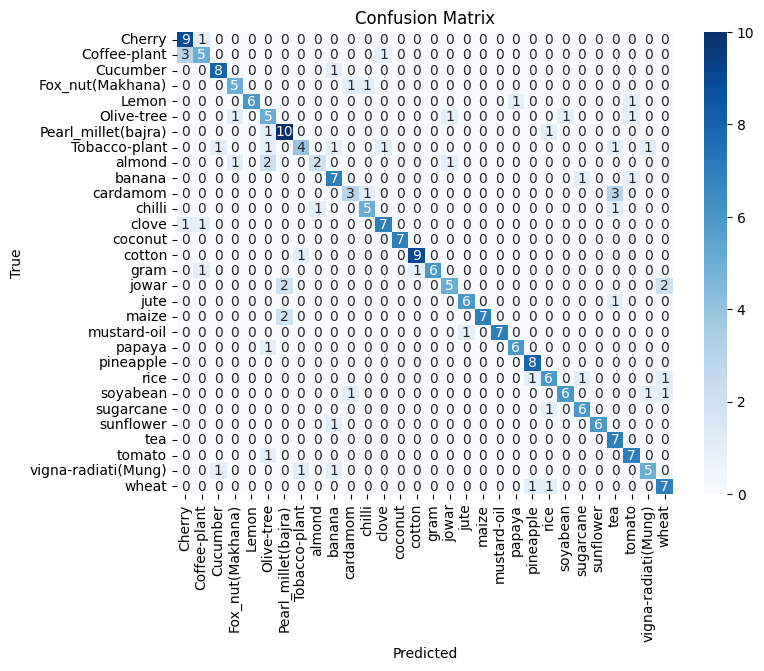

In [11]:
# 2. Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=idx_2_cls.values()))

# 3. Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=idx_2_cls.values(),
            yticklabels=idx_2_cls.values())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
